# Topic Modeling with Latent Dirichlet Allocation (LDA) and MALLET

The following notebook walks you through doing LDA topic modeling in Python using the Gensim package MALLET wrapper. We then export the LDA model and cleaned data so it can be used in our "ldaMalletResultsBarGraph" or "ldaMalletResultsWC" notebooks to create tables and graphs (ldaMalletResultsBarGraph), or tables and wordclouds (ldaMalletResultsWC) of your LDA topics for analysis. We do this to improve the reproducability of your results and increase efficiency by eliminating the need to repeat the entire process (which will create a slightly different model) if you decide you need to make changes to the visual output, but do not want the LDA model and topics to change. This notebook is where you would make changes that will impact the topics produced.  

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (ReD)](https://kb.iu.edu/d/apum). You will also need to have access to ReD through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](https://github.com/cyberdh/Text-Analysis/blob/drafts/textPrep-Py.ipynb) before you proceed further. The textPrep-Py notebook provides information and resources on how to get a Carbonate account, how to set up ReD, and how to get started using the Jupyter Notebook on ReD.   

### Run CyberDH environment
The code in the cell below points to a Python environment specificaly for use with the Python Jupyter Notebooks created by Cyberinfrastructure for Digital Humanities. It allows for the use of the different pakcages in our notebooks and their subsequent data sets.

##### Packages
- **sys:** Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- **os:** Provides a portable way of using operating system dependent functionality.

#### NOTE: This cell is only for use with Research Desktop. You will get an error if you try to run this cell on your personal device!!

In [1]:
import sys
import os
sys.path.insert(0,"/N/u/cyberdh/Carbonate/dhPyEnviron/lib/python3.6/site-packages")
os.environ["NLTK_DATA"] = "/N/u/cyberdh/Carbonate/dhPyEnviron/nltk_data"

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download.

In your terminal, packages can be installed by typing `pip install nameofpackage --user`. However, since you are using ReD and our Python environment, you will not need to install any of the packages below to use this notebook. Anytime you need to make use of a package, however, you need to import it so that Python knows to look in these packages for any functions or commands you use. Below is a brief description of the packages we are using in this notebook:  

- **re:** Provides regular expression matching operations similar to those found in Perl.
- **nltk:** A leading platform for building Python programs to work with human language data.
- **glob:** Finds all the pathnames matching a specified pattern according to the rules used by the Unix shell. 
- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- **pprint:** Provides a capability to “pretty-print” arbitrary Python data structures in a form which can be used as input to the interpreter.
- **collections:** Implements specialized container datatypes providing alternatives to Python's general purpose built-in containers, dict, list, set, and tuple.
- **matplotlib:**  Produces publication quality 2D graphics for interactive graphing, scientific publishing, user interface development and web application servers targeting multiple user interfaces and hardcopy output formats.
- **pickle:** Implements binary protocols for serializing and de-serializing a Python object structure. "Pickling" is the process whereby a Python object hierarchy is converted into a byte stream, and "unpickling" is the inverse operation, whereby a byte stream (from a binary file or bytes-like object) is converted back into an object hierarchy.
- **itertools:** Standardizes a core set of fast, memory efficient tools that are useful by themselves or in combination. Together, they form an “iterator algebra” making it possible to construct specialized tools succinctly and efficiently in pure Python.
- **zipfile:** Allows for handling of zipfiles.
- **tarfile:** Makes it possible to read and write tar archives, including those using gzip, bz2 and lzma compression.
- **gensim:** Python library for topic modelling, document indexing and similarity retrieval with large corpora.
- **spacy:** A library for advanced Natural Language Processing in Python and Cython.
- **logging:** Defines functions and classes which implement a flexible event logging system for applications and libraries.
- **warnings:** Allows for the manipulation of warning messages in Python.

Notice we import some of the packages differently. In some cases we just import the entire package when we say `import XYZ`. For some packages which are small, or, from which we are going to use a lot of the functionality it provides, this is fine. 

Sometimes when we import the package directly we say `import XYZ as X`. All this does is allow us to type `X` instead of `XYZ` when we use certain functions from the package. So we can now say `X.function()` instead of `XYZ.function()`. This saves time typing and eliminates errors from having to type out longer package names. I could just as easily type `import XYZ as potato` and whenever I use a function from the `XYZ` package I would need to type `potato.function()`. What we import the package as is up to you, but some commonly used packages have abbreviations that are standard amongst Python users such as `import pandas as pd` or `import matplotlib.pyplot as plt`. You do not need to us `pd` or `plt`, however, these are widely used and using something else could confuse other users and is generally considered bad practice. 

Other times we import only specific elements or functions from a package. This is common with packages that are very large and provide a lot of functionality, but from which we are only using a couple functions or a specific subset of the package that contains the functionality we need. This is seen when we say `from XYZ import ABC`. This is saying I only want the `ABC` function from the `XYZ` package. Sometimes we need to point to the specific location where a function is located within the package. We do this by adding periods in between the directory names, so it would look like `from XYZ.123.A1B2 import LMN`. This says we want the `LMN` function which is located in the `XYZ` package and then the `123` and `A1B2` directory in that package. 

You can also import more than one function from a package by separating the functions with commas like this `from XYZ import ABC, LMN, QRS`. This imports the `ABC`, `LMN` and `QRS` functions from the `XYZ` package.

In [2]:
import re
from nltk.corpus import stopwords
import glob
import pandas as pd
from pprint import pprint
from collections import Counter
import matplotlib.pyplot as plt
import pickle
import itertools as it
import zipfile
import tarfile

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from gensim.models.wrappers import LdaMallet

# spacy for lemmatization
import spacy

# Import warning
import logging
import warnings

This will give more details regarding error messages and will also ignore deprecation and user warnings. All the deprecation and user warnings in this code are not concerning and will not break the code or cause errors in the results.

In [3]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

### Getting your data

#### File paths
Here we are saving as variables different file paths that we need in our code. We do this so that they are easier to call later and so that you can make most of your changes now and not need to make as many changes later. 

First we use the `os` package above to find our `[HOME]` directory using the `environ` function. This will work for any operating system, so if you decide to try this out on your personal computer instead of ReD, the `homePath` variable will still be the path to your "home" directory, so no changes are needed.

Next, we combine the `homePath` variable with the folder names that lead to where our data is stored. Note that we do not use any file names yet, just the path to the folder. This is because we may want to read in all the files in the directory, or just one file. There are options below for doing both. We save the path as a variable named `dataHome`.

Now we assign paths we may not need, depending on our data. We assign these paths to `csvPath` and `jsonPath`. If we have twitter data in a .csv file, we will need to adjust the path assigned to `csvPath` to point to where our .csv twitter data resides. Just the folder, not the actual file. If our twitter data is in a .json file, then we need to adjust the path assigned to `jsonPath` so it points to the folder our .json twitter data resides. If our data is in .txt format, then do not worry about either of these variables.

Next, since we are using MALLET to do our LDA, you need to [download](http://mallet.cs.umass.edu/download.php) the MALLET zipfile, unzip it and provide the path to the extracted folder. We recommend saving the extracted folder in your "Carbonate" directory which is also your "home" directory. This way you will not need to adjust anything in the last line as it should point to the folder needed to run MALLET. We save this file path as the variable `malletPath`.

Then we join the file path assigned to the `homePath` variable to another file path that leads to a folder for our LDA model, LDA dictionary, and other needed data and assign it to the variable `cleanDataPath`.

Now, we join the file path assigned to the `cleanDataPath` variable to other file paths to point to what we want to name our output files for our cleaned data (`cleanData`), our LDA dictionary (`cleanDict`), our LDA model (`cleanModel`), and our original data uncleaned and converted to a list (`origData`). If you wish to name the files something else, then change the name in quotes in all of the variables just listed.

Lastly, we assign a file path to the `cleanDF` variable. Here we may store a .csv file later in the code depending on our data.

In [4]:
homePath = os.environ["HOME"]
dataHome = os.path.join(homePath, "Text-Analysis-master", "data")
csvPath = os.path.join(dataHome, "twitter", "CSV")
jsonPath = os.path.join(dataHome, "twitter", "JSON")
malletPath = os.path.join(dataHome,"mallet-2.0.8", "bin", "mallet") # update this path
cleanDataPath = os.path.join(homePath, "Text-Analysis-master", "TopicModeling", "LDA", "cleanedData", "malletModel")
cleanData = os.path.join(cleanDataPath, "ldaDataClean")
cleanDict = os.path.join(cleanDataPath, "ldaDict")
cleanModel = os.path.join(cleanDataPath, "ldaModel")
origData = os.path.join(cleanDataPath, "ldaDataOrig")
cleanDF = os.path.join(homePath, "Text-Analysis-master", "TopicModeling", "LDA", "cleanedCSV")

### Set needed variables
This is where you will make some decisions about your data and set the necessary variables. Much like the file path variables above, we do this so you do not need to make as many changes later.

**source**<br>
First, we need to decide if we want our code to read all the files in a directory or just a single file. If we want all the files in a directory then we set `source` equal to `"*"`. This means 'all' and will be added to the file type later in the code. If you want a single file change `"*"` to the file name without the ".txt" or ".csv" or ".json" at the end. So if you have a file named "myFile.txt" you would set `source` equal to `"myFile"` without the ".txt".

**fileType**<br>
Next we assign the file type our data comes in to a variable. At the moment the only options are ".txt", ".csv" or ".json". The ".txt" format is the most popular format for analysis of a text or corpus, while ".csv" and ".json" are the most common formats for twitter data. We assign the format to the `fileType` variable. It should look like this: `fileType = ".txt"`.

**chunkLevel**<br>
The `chunkLevel` variable is only for file types of ".txt" so if you have a ".csv" or ".json" you want to assign `None` to `chunkLevel` or it will cause problems in other parts of the code later since we do not keep track of file names for the ".csv" and ".json" files. If your data is in ".txt" format, then you need to determine if you want to chunk your corpus by lines, files, or directories.

We do this in case your data is a single ".txt" file, multiple text files, or multiple directories of text files. The LDA algorithm needs to have multiple chunks to accurately weigh and order words into topics. If you have multiple documents then the documents themselves are the chunks. If you have a single document, then we need to create chunks, and we do this by spliting the document up by line and each line is a separate chunk.

If you want to separate by individual files, then set `chunkLevel` equal to `"files"`(with the quotes). If you want to separate a line at a time and have each line be it's own entity or 'chunk' then set `chunkLevel` equal to `"lines"` (again, with the quotes). If you have multiple directories, each containing multiple .txt files and you want to use the directories as your "chunks" then assign `"direct"` (with the quotes) to `chunkLevel`. For example, if you have a lot of different authors, and you have a directory for each author containing that particular author's works and you want to use LDA to see which authors tended to cover similar topics or what topics were prevelant amongst the particualr group of authors, you would assign `"direct"` to `chunkLevel`. On another note, if you set `source` equal to `"*"` then you will want to set `chunkLevel` equal to `"files"` or `"direct"`. If you set `source` equal to a specific file name, then you will want to set `chunkLevel` equal to `"lines"`. 

**n**<br>
The `n` variable is where you assign the number of lines you would like to chunk the document into if you set `chunkLevel` equal to `"lines"`. This variable is not used if `chunkLevel` is `"files"` or `"direct"`.

**nltkStop**<br>
The `nltkStop` is where you determine if you want to use the built in stopword list provided by the NLTK package. They provide stopword lists in multiple languages. If you wish to use this then set `nltkStop` equal to `True`. If you do not, then set `nltkStop` equal to `False`.

**customStop**<br>
`customStop` is for if you have a .txt file that contains additional stopwords that you would like to read in and have added to the existing `stopWords` list. You do *NOT* need to use the NLTK stopwords list in order to add your own custom list of stopwords. **NOTE: Your custom stopwords file needs to have one word per line as it reads in a line at a time and the full contents of the line is read in and added to the existing stopWords list.** If you have a list of your own then set `customStop` equal to `True`. If you do not have your own custom stopwords list then set `customStop` equal to `False`.

**spacyLem**<br>
`spacyLem` is where we decide if we want to use the spaCy package lemmatization function. What is lemmatization? Lemmatization is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form. In computational linguistics, lemmatisation is the algorithmic process of determining the lemma of a word based on its intended meaning. Unlike stemming, lemmatisation depends on correctly identifying the intended part of speech and meaning of a word in a sentence, where as stemming does not take the context of the word into account. For example, if we lemmatize the word "running" or "ran" it will become the word "run". If we stem the word "running" most stemmers will convert it to "runn" only removing the "ing" and leaving the second "n". Stemming will also change "police" and "policy" both to "polic" and they will be considered the same word by the LDA script. The lemmatizer will leave both words as "police" and "policy". This is useful and recommended for topic modeling as it allows the algorithm to just consider "walk" instead of "walking", "walked", and "walk" and thereby can increase the accuracy of your results. To use the spacy lemmatizer assign `True` to `spacyLem`. If you do not wish to use the lemmatizer assign `False` to `spacyLem`.

**coherence**<br>
`coherence` is where you decide if you want to calculate the coherence score for not just the default 20 topics, but if you want to calculate the coherence score beginning with 10 topics and going up by 10 until you get to 80 topics. This step takes a LONG time as you are running LDA on your corpus at least eight times and also running the coherence algorithm eight times as well. The idea behind the coherence score is that the higher the score, the more "coherent" or "understandable" your topics should be. This step is meant to help you determine the number of topics that are most likely to help make sense of your data. Again, this is a computer algorithm and so is not always right about what makes sense to humans, so we have given you the option to run all the coherence scores, or just stick with the default number of topics. If you want to see all the coherence scores assign `True` to `coherence`. If you want just the default 20 topics and do not need to see a coherence score, assign `False` to `coherence`. **NOTE:** If you assign `True` to `coherence` the code default is to automatically apply the number of topics with the highest coherence score to the LDA algorithm. If you want to see the coherence scores, but want to decide on your own which number of topics to apply to the LDA algorithm, you will need to make changes the appropriate cell of code below (don't worry, there is a note letting you know which cell it is when you get to it).

**stopLang**<br>
Now we choose the language we will be using for the nltk stopwords list. If you need a different language, simply change `"english"` (keep the quotes) in the `stopLang` variable to the anglicized name of the language you wish to use (e.g. "spanish" instead of "espanol" or "german" instead of "deutsch"). For a list of available stopword languages in nltk add a new code cell and type `print(stopwords.fileids())` and the list of available languages will print out below the cell.

**lemLang**<br>
Now we choose the language for our lemmatizer. The languages available for spacy include the list below and the abbreviation spacy uses for that language:

- **English:** `"en"`
- **Spanish:** `"es"`
- **German:** `"de"`
- **French:** `"fr"`
- **Italian:** `"it"`
- **Portuguese:** `"pt"`
- **Dutch:** `"nl"`
- **Multi-Language:** `"xx"`

To choose a language simply type the two letter code following the angliscized language name in the list above. So for Spanish it would be `"es"` (with the quotes) and for German `"de"` and so on.

**encoding, errors**<br>
The variable `encoding` is where you determine what type of encoding to use (ascii, ISO-8850-1, utf-8, etc...). We have it set to `"utf-8"` at the moment as we have found it is less likely to have any problems. However, errors do occur, but the encoding errors rarely impact our results and it causes the Python code to exit. So instead of dealing with unhelpful errors we ignore the ones dealing with encoding by assigning `"ignore"` to the `errors` variable. If you want to see any encoding errors then change `"ignore"` to `None` (without quotes).

**textColIndex**<br>
The `textColIndex` variable is only applicable if our `fileType` is ".csv" or ".json". The `textColIndex` variable is where we put the header name of the dataframe column that will contain the content we are interested in from our tweets. Generally the content of the tweets are labeled as "text" since this is the label given to the tweet content when it is pulled directly from the Twitter API. For this reason our default value assigned to the `textColIndex` is `"text"`. If for some reason the tweet content has a different label or header, and you need to change this, remember to keep the quotes around the new label.

**stopWords, docs**<br>
The `stopWords =[]` variable is simply an empty list. This is where the words from the nltk stopword list or your custom stopword list or both combined or neither (depending on what you decide) will reside later on. You do not need to do anything to this line of code.

The `docs = []` variable also does not need to have anything done to it as it is also an empty list that will be added to later.

In [5]:
source = "*"
fileType = ".txt"
chunkLevel = "files"
n = 100
nltkStop = True
customStop = True
spacyLem = True
coherence = True
stopLang = "english"
lemLang = "en"
encoding = "utf-8"
errors = "ignore"
textColIndex = "text"
stopWords = []
docs = []

### Stopwords
If you assigned `True` to `nltkStop` above then this will add the NLTK stopwords list to the empty list named `stopWords`.

You already chose your desired language above, so you do not need to do that now. 

If you need to add a few more words to the `stopWords` list that are specific to your dataset (such as common names or phrases that may make your results inaccurate), then add those to the `stopWords.extend(['would', 'said', 'says', 'also'])` part of the code in the square brackets with single quotes around each word and separated by a comma.

In [6]:
# NLTK Stop words
if nltkStop is True:
    stopWords.extend(stopwords.words(stopLang))
    stopWords.extend(['would', 'said', 'says', 'also'])

#### Add own stopword list

Here is where your own stopwords list is added if you assigned `True` to `customStop` above. Here you will need to change the folder names and file name to match your folders and file. Remember to put each folder name in quotes and in the correct order always putting the file name including the file extension (.txt) last.

In [7]:
if customStop is True:
    stopWordsFilepath = os.path.join(homePath, "Text-Analysis-master", "data", "earlyModernStopword.txt")

    with open(stopWordsFilepath, "r",encoding = encoding) as stopfile:
        stopWordsCustom = [x.strip() for x in stopfile.readlines()]

    stopWords.extend(stopWordsCustom)

#### Unzip folders

Here we are unzipping files. Since twitter data can be rather large it is often necessary to compress it into a '.zip' file in order to upload it to places such as GitHub. For this reason, we have setup some code to go in and automatically extract all the items in a compressed '.zip' file so you don't have to and so you don't get errors later. If the data is not in a '.zip' file there is no need to worry, it will not give an error if there are no files ending in '.zip' in your directory.

We also extract the mallet data here and save it to our data folder for use further down in the code.

You should not need to make any changes as we use the same variables containing our file paths as above, so if you need to make adjustments to the file paths, you need to make them there, specifically to the `dataHome` variable.

In [8]:
if fileType == ".csv":
    allZipFiles = glob.glob(os.path.join(csvPath,"*.zip"))
    for item in allZipFiles:
        fileName = os.path.splitext(csvPath)[0]
        zipRef = zipfile.ZipFile(item, "r")
        zipRef.extractall(fileName)
        zipRef.close()
        os.remove(item)
if fileType == ".json":
    allZipFiles = glob.glob(os.path.join(jsonPath,"*.zip"))
    for item in allZipFiles:
        fileName = os.path.splitext(jsonPath)[0]
        zipRef = zipfile.ZipFile(item, "r")
        zipRef.extractall(fileName)
        zipRef.close()
        os.remove(item)

if not glob.glob(os.path.join(dataHome,"*.tar.gz")):
    None
else:
    fname = "mallet-2.0.8.tar.gz"
    if fname.endswith(".tar.gz"):
        tar = tarfile.open(os.path.join(dataHome, fname), "r:gz")
        tar.extractall(dataHome)
        tar.close()
        os.remove(os.path.join(dataHome, fname))

### Reading in .txt files
The code below reads in text files if you chose fileType `".txt"` above. It can do this in three ways. We can read in single file, a single directory, or we can read in multiple directories and it will do these based on what you chose for `source` above. Then it will chunk your data, either by line, document, or by directory, and this will depend on what you chose for `chunkLevel` above. 

In [9]:
if fileType == ".txt":
    if chunkLevel == "files":
        paths = glob.glob(os.path.join(dataHome, "shakespeareFolger", source + fileType))
        for path in paths:
            with open(path, "r", encoding = encoding, errors = errors) as file:
                 # skip hidden file
                if path.startswith('.'):
                    continue
                docs.append(file.read().strip('\n').splitlines())
                
    elif chunkLevel == "lines":
        paths = glob.glob(os.path.join(dataHome, "shakespeareFolger", source + fileType))
        for path in paths:
            with open(path, "r", encoding = encoding, errors = errors) as file:
                 # skip hidden file
                if path.startswith('.'):
                    continue
                for line in file:
                    stripLine = line.strip()
                    if len(stripLine) == 0:
                        continue
                    docs.append(stripLine.split())
    elif chunkLevel == "direct":
        folderTextCSV = "folderText.csv"
        paths = []
        txt = []
        dataPath = os.path.join(dataHome, "starTrek")
        for folder in sorted(os.listdir(dataPath)):
            if not os.path.isdir(os.path.join(dataPath, folder)):
                continue
            for file in sorted(os.listdir(os.path.join(dataPath, folder))):
                paths.append(((dataPath, folder, file)))
        df = pd.DataFrame(paths, columns = ["Root", "Folder", "File"])
        df["Paths"] = df["Root"].astype(str) +"/" + df["Folder"].astype(str) + "/" + df["File"].astype(str)
        for path in df["Paths"]:
            if not path.endswith(".txt"):
                continue
            with open(path, "r", encoding = encoding, errors = errors) as f:
                t = f.read().strip().split()
                txt.append(t)
        df["Text"] = pd.Series(txt)
        df["Text"] = ["".join(map(str, l)) for l in df["Text"].astype(str)]
        d = {'Text':'merge'}
        dfText = df.groupby(['Folder'])["Text"].apply(lambda x: ' '.join(x)).reset_index()
        
        docs.extend(dfText["Text"].tolist())
        dfText.to_csv(os.path.join(cleanDF, folderTextCSV))
    else:
        None
else:
    None

### Reading in .csv and .json files

If you chose `".csv"` as your `fileType` up above, then the first `if` statement in the code below reads in ".csv" files and saves the contents to a dataframe using the Pandas package. It will read in either an entire directory or a single ".csv" file depending on what you chose for `source` above. 

Once we have read in the ".csv" file using the Pandas `read_csv` function, we need to concatenate the ".csv" files if there are multiple. Because of this it is important that your ".csv" files have an identical column count and each column has identical header names or you will get errors. If you have a single ".csv" file then you should be fine for this step. We assign this process to the variable `cdf` so we can use it later.

Now we convert our `cdf` to a pandas dataframe. This allows for easier manipulation of the data in the next line.

Finally, we pull in the column containing the data we are interested in which we assigned to the variable `textColIndex` earlier and turn it into a list assigned to the variable `tweets`.

If you chose `".json"` for your fileType, then the second `if` statement will read in ".json" files and save the content to a dataframe using the Pandas package much like the ".csv" file process described above. The only difference is that we use the Pandas function `read_json` instead of `read_csv`. Everything else is exactly the same as what is described above in the ".csv" section. 

In [10]:
if fileType == ".csv":
    allFiles = glob.glob(os.path.join(csvPath, source + fileType))     
    df = (pd.read_csv(f, engine = "python") for f in allFiles)
    cdf = pd.concat(df, ignore_index=True)
    cdf = pd.DataFrame(cdf, dtype = 'str')
    tweets = cdf[textColIndex].values.tolist()
if fileType == ".json":
    allFiles = glob.glob(os.path.join(jsonPath, source + fileType))     
    df = (pd.read_json(f, encoding = encoding, lines = True) for f in allFiles)
    cdf = pd.concat(df, ignore_index=True)
    cdf = pd.DataFrame(cdf, dtype = 'str')
    tweets = cdf[textColIndex].values.tolist()

### Data variable

Now we need to change our variable containing our data (either docs or tweets from above) to the variable `data` since this is the variable used going forward and it saves you from having to switch between `tweets` and `docs` later in the code. If you read in ".csv" or ".json" files then your data is saved in the `tweets` list and if you read in ".txt" files then it is in the `docs` list. This code says if the length of the `docs` list is greater than 0 then assign `docs` to the variable data. However, if the length of `tweets` is greater than 0 then assign `tweets` to the variable `data`.

If your data was in `docs` and was from a single document, then you may want to chunk the data by lines. The "if...else" statement says if `chunkLevel` is `"files"` or `"direct"` then `data = docs`. If `chunkLevel` is `"lines"` then we chunk the document by `n` lines with `n` being the number we assigned to that variable up above.

If your data was in `tweets` then it most likely needs some additional cleaning. So the next chunk of code removes URLS and new line characters from the `data` variable if the length of `tweets` is greater than 0.

The last line prints out the length of our collection. If you are reading in a single document this will print the number of chunks created by considering every `n` lines a chunk. If you chunked by files then it will print out the number of files, if you chunked by directory than the number of directories. If you are reading in tweets than it will print out the number of tweets.

In [11]:
if len(docs) > 0:
    if chunkLevel == "files" or "direct":
        data = docs
    elif chunkLevel == "lines":
        data = []
        for i in list(it.zip_longest(*(iter(docs),)*n)):
            data.append(i)
    else:
        None
elif len(tweets) > 0:
    data = tweets
    # Remove Urls
    data = [re.sub(r'http\S+', '', sent) for sent in data]
    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
else:
    None
print(len(data))

36


### Tokenizing

This block of code separates each chunk of text into a list of individual words. In the process it also lower cases all the words and removes punctuation. If you wish to keep the punctuation change `deacc = True` to `deacc = False`.

In [12]:
def sentToWords(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

dataWords = list(sentToWords(data))

print(len(dataWords))

36


### Find Bigrams and Trigrams

This code will most likely not need to be adjusted. It creates a model of bigrams and trigrams in your dataset that occur frequently and then connects them with an underscore so the LDA algorithm will later consider them as one word. This is a good idea for items like 'new york' or 'new zealand' or 'Ho Chi Minh'. If we do not combine these frequently occuring phrases then 'new' and 'york' will be considered independently and give us less accurate results.

However, you may wish to adjust two settings depending on your data. The first is `min_count` and we assign a number to a variable `minCount` that will be used for `min_count` in the code. The other setting you might want to adjust is `threshold` and for this we assign a number to a variable `tHold` that will be used for `threshold` in the code.

Right now we have a `min_count` of 5 and a `threshold` of 100. The `min_count` is simply the minimum number of times the bigram or trigram needs to occur in order to be combined with an underscore. The `threshold` is a score that the bigram or trigram needs to exceed in order to be combined with an underscore. The score is determined by using this formula: (bigram_count - min_count)\*vocab_count/(wordA_count \* wordB_count). So let's say we have the bigram "good_lord" and it appears 30 times in a text of 10,000 words where "good" appears 60 times total and "lord" appears 40. With our `min_count` set to 5 we get the following: (30 - 5)\*10000/(60 \* 40) = 104.167 which means since our `threshold` is set to 100 "good_lord" will be combined with an underscore and made into a bigram. If the resulting score is above your `threshold` then the ngram is considered important enough to combine with an underscore and will be viewed as one word for the LDA scoring later. Therefore, if you increase the `threshold`, you will get fewer bigrams and trigrams. If our threshold was set to 110, then "good" and "lord" would not be combined into "good_lord".

The Phraser function takes the model you built with the Phrases function and cuts down memory consumption of Phrases, by discarding model state not strictly needed for the bigram detection task.

Lastly, we take a look at the ngrams created from the first item in our dataset only, so the results are for only one chunk, not the whole dataset. We do this by counting the number of words that contain an underscore as this is used to connect the words in the ngram together. **NOTE:** The output is only to test if the ngrams work so you will probably see ngrams containing stopwords. We will create a few functions next and then apply them to remove stopwords, create bigrams, and lemmatize the chunk.

In [13]:
# Variables
minCount = 5
tHold = 100

# Build the bigram and trigram models
bigram = Phrases(dataWords, min_count=minCount, threshold=tHold) # higher threshold fewer phrases.
trigram = Phrases(bigram[dataWords], threshold=tHold)  

# Removes model state from Phrases thereby reducing memory use.
bigramMod = Phraser(bigram)
trigramMod = Phraser(trigram)

# See bigram/trigram example
testNgram = trigramMod[bigramMod[dataWords[0]]]
char = "_"
nGrams = [s for s in testNgram if char in s]
            
pprint(Counter(nGrams))

Counter({'poor_tom': 13,
         'foul_fiend': 11,
         'hundred_knights': 6,
         'gav_st': 3,
         'alack_alack': 3,
         'take_heed': 2,
         'good_morrow': 2,
         'how_fares': 2,
         'wast_born': 1,
         'both_sides': 1,
         'an_ass': 1,
         'ha_ha_ha': 1,
         'hundred_pound': 1,
         'ha_ha': 1,
         'cut_off': 1,
         'heigh_ho': 1,
         'fie_fie_fie': 1,
         'looking_glass': 1})


### Functions
We need to create a function in order to stem and tokenize our data. Any time you see `def` that means we are **DE**claring a **F**unction. The `def` is usually followed by the name of the function being created and then in parentheses are the parameters required by the function. After the parentheses is a colon, which closes the declaration, then a bunch of code below which is indented. The indented code is the program statement or statements to be executed. Once you have created your function all you need to do in order to run it is call the function by name and make sure you have included all the required parameters in the parentheses. This allows you to call the function without having to write out all the code in the function every time you wish to perform that task.

### Some functions

Below are functions we are creating that perform certain tasks. First we are creating a function to remove the stopwords that are in our stopword list we created previously. Then we create functions to apply our bigram and trigram code from above. 

Lastly, if you set `spacyLem` equal to `True` above then we will create the `lemmatization` function. If you set it equal to `False` then it will not create the function.

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def removeStopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopWords] for doc in texts]

def makeBigrams(texts):
    return [bigramMod[doc] for doc in texts]

def makeTrigrams(texts):
    return [trigramMod[bigramMod[doc]] for doc in texts]


if spacyLem is True:
    def lemmatization(texts):
        """https://spacy.io/api/annotation"""
        textsOut = []
        lemmaPOS = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            textsOut.append([token.lemma_ for token in doc if token.lemma_ != '-PRON-'])
            lemmaPOS.append([token.text and token.lemma_ and token.pos_ for token in doc])
        return textsOut
        print(lemmaPOS[:10])

Now we apply the functions. There are really only two parts where you may need to make changes and they are in the lines `dataWordsNgrams = makeBigrams(dataWordsNostops)` and `nlp = spacy.load(lemLang, disable=\['parser', 'ner'\])`.

The `dataWordsNgrams` variable is where you will change between either using the `makeBigrams` or `makeTrigrams` functions above. If you only want bigrams, then keep the code as it is. If you want both bigrams and trigrams to be considered in your topic modeling, then change the `makeBigrams` part to `makeTrigrams` and it will now calculate both bigrams and trigrams. 


Adjustments to the other line that might need changes mentioned above may only be necessary if you previously set `spacyLem` equal to `True`. Even if you set it to `True` you may still not need to make changes. The line of code you may want to change is `nlp = spacy.load('lemLang', disable=\['parser', 'ner'\])` and is where you can disable the parser and named entity recognizer (ner). 

If you wish for your words to be parsed simply remove `'parser'` from the `disable=` bracket. Same for `ner`. If you wish to use both the parser and ner then just remove the `, disable=\['parser', 'ner'\]` entirely (including the preceding comma), but leave the closing parantheses. The reason we disable to 'parser' and 'ner' is because they slow down the lemmatization process and are not necessary to lemmatize our dataset.

Lastly, we print out the ngrams we find in the first chunk (document or line) of our data. Notice there are no trigrams included. This is because we applied only the `makeBigrams` function from above. If we had applied the `makeTrigrams` function we would have both bigrams and trigrams. Feel free to change this in the code as described above. If we set `spacyLem` equal to `True` then we will get the first 10 words, their lemmatized form (which sometimes is identical to the word being lemmatized), with their parts of speech tagging from the `lemmatization` function above. Below this is a list of the lemmatized bigrams from the first chunk of our data. If we set it to `False` then we will get bigrams from the first chunk that have not been lemmatized.

In [15]:
# Remove Stop Words
dataWordsNostops = removeStopwords(dataWords)

# Form Bigrams
dataWordsNgrams = makeBigrams(dataWordsNostops)

if spacyLem is True:
    # Initialize spacy language model, eliminating the parser and ner components
    nlp = spacy.load(lemLang, disable=['parser', 'ner'])
    
    # Do lemmatization tagging
    
    dataLemmatized = lemmatization(dataWordsNgrams)
    lemmaPOS = []
    for sent in dataLemmatized:
        lemmaNLP = nlp(" ".join(sent))
        for token in lemmaNLP:
            lemmaPOS.append([token.text, token.lemma_, token.pos_])
    print(lemmaPOS[:10])
    

    # Find ngrams and count number of times they occur
    dataNgrams = [s for s in dataLemmatized[0] if char in s]
    
else:
    dataNgrams = [s for s in dataWordsNgrams[0] if char in s]
print(Counter(dataNgrams))

[['thought', 'thought', 'PROPN'], ['king', 'king', 'PROPN'], ['affect', 'affect', 'VERB'], ['duke', 'duke', 'PROPN'], ['albany', 'albany', 'PROPN'], ['cornwall', 'cornwall', 'PROPN'], ['division', 'division', 'PROPN'], ['kingdom', 'kingdom', 'NOUN'], ['appear', 'appear', 'VERB'], ['duke', 'duke', 'PROPN']]
Counter({'poor_tom': 13, 'foul_fiend': 11, 'gav_st': 3, 'alack_alack': 3, 'ha_ha': 2, 'good_morrow': 2, 'fie_fie': 2, 'wast_born': 1, 'heigh_ho': 1, 'looking_glass': 1})


### Create the Dictionary and Corpus needed for Topic Modeling

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

First, we need to determine if we are using lemmatized data or not. To do this we are using another `if` statement. Here, `if` we set `spacyLem` equal to `True` then we create the id2word dictionary based off of the lemmatized version of the data. However, if we did not, (denoted by `else`) then we will create the id2word dictionary based on the non-lemmatized data.

Gensim creates a unique id for each word in the document. For example, (0, 1) implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

In [16]:
if spacyLem is True:
    # Create Dictionary
    id2word = corpora.Dictionary(dataLemmatized)

    # Create Corpus
    texts = dataLemmatized
else:
    # Create Dictionary
    id2word = corpora.Dictionary(dataWordsNgrams)

    # Create Corpus
    texts = dataWordsNgrams
    
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [17]:
id2word[10]

'abuse'

Or, you can see a human-readable form of the corpus itself.

In [18]:
# Human readable format of corpus (term-frequency)
hReadable = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
for i in hReadable:
    print(i[:10])

[('abate', 1), ('abatement', 1), ('abhor', 1), ('abhorred', 1), ('abjure', 1), ('able', 1), ('abode', 1), ('abominable', 1), ('abroad', 2), ('absolute', 1)]


### FIND OPTIMAL NUMBER OF TOPICS

If you set `coherence` to `False` above, then this cell is skipped. 

However, if you assigned `True` to `coherence` above, then we will try and find the optimal number of topics. To do this we build many LDA models with different values of number of topics and pick the one that gives the highest coherence value. We do this by creating the function `computeCoherenceValues`. You will most likley not want to make changes to the function itself. 

You may want to make changes to the variables that precede the function, namely `start`, `lmt`, and `steps`. The `start` variable is where you assign the number of topics you want to start with to determine the number of topics with the highest coherence score. Currently 10 is assigned to `start` the `start` parameter is inclusive, so it includes the number we assign to that parameter. The `lmt` variable is where you assign the number of topics at which you want to stop testing coherence scores. Notice that `lmt` is set to 81, not 80. This is because the `limit` parameter in the `computeCoherenceValues` function is exclusive, meaning it includes everything before that number, but not the number itself. The `steps` variable is where we assign the increments by which we go from `start` to `lmt`. Currently it is set to 10, so the algorithms will be applied every 10 topics from 10 to 80 with the current settings. Therefore, we should see coherence scores for 10, 20, 30, 40, 50, 60, 70, and 80 topics. 

Note that you want to make sure the assignments to `start`, `lmt`, and `steps` all add up. If I keep the numbers assigned to `start` and `lmt`, but change `steps` to 20, then the function will run MALLET and compute coherence scores for 10, 30, 50, and 70 topics, but will not run for 80 topics as it tries to go to 90, but stops because it has exceeded the 81 limit. However, the assigned `steps` do not allow it to run the algorithms for 80 topics, so it ends with 70.

Feel free to adjust these variables to suit your corpus, just make sure the `steps` you count by make sense with assigned `start` and `lmt`.

In [19]:
if coherence is True:
    #Variables
    start = 10
    lmt = 81
    steps = 10
    def computeCoherenceValues(dictionary, corpus, texts, limit, start=start, step=steps):
        """
        Compute c_v coherence for various number of topics

        Parameters:
        ----------
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics

        Returns:
        -------
        modelList : List of LDA topic models
        coherenceValues : Coherence values corresponding to the LDA model with respective number of topics
        """
        coherenceValues = []
        modelList = []
        
        for numTopics in range(start, limit, step):
            model = gensim.models.wrappers.LdaMallet(malletPath, corpus=corpus, num_topics=numTopics, id2word=id2word, iterations = 1000, workers = 1, prefix=cleanDataPath, optimize_interval = 10, random_seed = 42)
            modelList.append(model)
            coherenceModel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherenceValues.append(coherenceModel.get_coherence())

        return modelList, coherenceValues
else:
    None

If you set `coherence` equal to `False` then this cell is skipped.

If otherwise...

The `computeCoherenceValues()` trains multiple LDA models and their corresponding coherence scores. In addition, if `True` was assigned to `spacyLem` then the algorithms are run on the lemmatized version of the corpus, if `False` was assigned to `spacyLem` then the algorithms are run on the non-lemmatized version of the corpus. 

In [20]:
# Can take a long time to run.
if coherence is True:
    if spacyLem is True:
        modelList, coherenceValues = computeCoherenceValues(dictionary=id2word, corpus=corpus, texts=dataLemmatized, start=start, limit=lmt, step=steps)
    else:
        modelList, coherenceValues = computeCoherenceValues(dictionary=id2word, corpus=corpus, texts=dataWordsNgrams, start=start, limit=lmt, step=steps)
else:
    None

If we set `coherence` equal to `True` we will want to visualize the coherence scores for each number of topics to help us decide how many topics we should use going forward.

Choosing a number of topics that marks the end of a sharp increase in topic coherence scores usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics. If you see the same keywords being repeated in multiple topics, it’s probably a sign that the number of topics is too large. To choose the number of topics that might be best do not just use the highest coherence score. There are other factors that need to be considered. If the coherence score just seems to keep climbing higher and higher along with the number of topics, it might be best to find the number where it appears to stop and flatten out a bit before continuing to ascend. You do not want to run the risk of having too many or too few topics.

However, further down we have the default number of topics to be the number of topics with the highest coherence score if `True` was assigned to `coherence`. If your coherence score results lead you to believe that the highest score is not the "optimal" number of topics, then you will want to change the number of topics to the number you think best exemplifies the recommendations for choosing the number of topics in the paragraph above when you get to that part of the code.

If you set `coherence` equal to `False` then this cell is skipped.

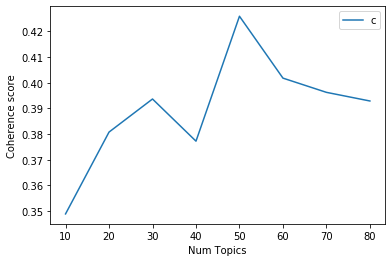

In [21]:
if coherence is True:
    # Show graph
    limit=lmt; start=start; step=steps;
    x = range(start, limit, step)
    plt.plot(x, coherenceValues)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherenceValues"), loc='best')
    plt.show()
else:
    None

If `coherence` was set to `False` then this cell is skipped.

If otherwise...

Now that we have a visual, it may help to go back and look at the actual numbers. The code below lists the coherence score for each number of topics we have selected as well as the number of topics which produced the highest coherance score.

In [22]:
if coherence is True:
    # Print the coherence scores
    cval = coherenceValues
    maxCoVal = cval.index(max(cval))
    mcv = round(maxCoVal, 4)
    
    for m, cv in zip(x, coherenceValues):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    print(" ")
    print("Optimal Number of Topics is", x[mcv])
    
        
else:
    None

Num Topics = 10  has Coherence Value of 0.3489
Num Topics = 20  has Coherence Value of 0.3808
Num Topics = 30  has Coherence Value of 0.3937
Num Topics = 40  has Coherence Value of 0.3772
Num Topics = 50  has Coherence Value of 0.4259
Num Topics = 60  has Coherence Value of 0.4018
Num Topics = 70  has Coherence Value of 0.3963
Num Topics = 80  has Coherence Value of 0.3929
 
Optimal Number of Topics is 50


### USING MALLET
First we choose some important settings for our LDA model. 
If we assigned `True` to `coherence` then we want to make changes to the variables after `if coherence is True:`, but before `else:`. If we assigned `False` to the `coherence` variable, then we want to make our changes to the variables after `else:` in the cell below.

If you assigned `True` to `coherence` then the number of topics with the highest coherence score is assigned to the `nTopics` variable. **NOTE: If you feel that a different number of topics is optimal, then change the default** `x[mcv]` **to the number of topics that works best for your corpus.** If you assigned `False` to the `coherence` variable the `nTopics` variable is assigned 20 as the default number of topics. Feel free to adjust this number as needed for your particular corpus.

The `workers` variable is where we determine the number of nodes beings used. For ReD this number needs to stay at 1 as you are only allowed to use one node at a time. If you are using this on your own system, then do not exceed the number of cores on your computer.

`nIter` is where you choose the number of training passes or iterations you want to make over the data. Here it is better to error on the side of the number being high. However, you want to balance this with any time constraints you might have. More iterations take more time. Note that the default is 1000, however, there are instances where this parameter has been set as low as 10. Feel free to play with this number as well to find an appropriate balance.

`optInt` is where we set the number of iterations that take place before the algorithm checks what the optimal hyperparameters are. The hyperparameters are the alpha and beta levels. Alpha represents document-topic density and Beta represents topic-word density. If you raise the value of alpha, then the documents are composed of more topics and if you lower the value of alpha the documents are composed of less topics. If you raise the Beta number, the topics are composed of more words from the corpus, if you lower the Beta value the topics are composed of fewer words from the corpus. Currently, every 10 iterations the algorithm checks which alpha and Beta scores are most optimal. Feel free to change this and see the difference in your results.

`seed` is where you set the seed. The seed helps with reproducability so if someone else runs the code on your dataset with these settings they should get the same answer. The seed basically tells the algorithm to start in the same spot, otherwise a random number generator chooses a different starting location each time. **Note:** the topics will be the same, but possibly in a different order even when you set the seed, so if you run it and get a set of words for topic 5, then if you run it again with the exact same settings on the exact same dataset what was topic 5 might now be topic 12, but the topic will contain the same words ordered by weight/importance. 

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. If you are running this on ReD and have saved the Text-Analysis-master folder in your home directory, then the default file path assigned to the `malletPath` variable should point to the version of MALLET that came with this repo. 

If you are running this on your own computer, then if you also saved this repo to your home directory the path assigned to the `malletPath` variable should point to MALLET. If you saved the repo somewhere other than your home directory then as long as you have [downloaded](http://mallet.cs.umass.edu/download.php) the MALLET zipfile, extracted it and provided the path to the extracted mallet folder in the `malletPath` variable in the cell where we assign file paths to variables towards the top, then you should be good.  

Adjustments should be made according to your specific corpus.

After the variables are two lines of code.

The first line of code runs the MALLET algorithm using our desired number of topics, number of workers, number of iterations, and set seed.

The final line of code says that we want to print the first three topics with the top ten words in each topic based on their weight. We do this to check that the algorithm is working.

In [23]:
if coherence is True:
    #Variables
    nTopics = x[mcv]
    workers = 1
    nIter = 1000
    optInt = 10
    seed = 42
    
    # Select the model and print the topics
    optimalModel = LdaMallet(malletPath, corpus=corpus, num_topics=nTopics, id2word=id2word, iterations = nIter, workers = workers, prefix=cleanDataPath, optimize_interval = optInt, random_seed = seed, topic_threshold=0)
    pprint(optimalModel.print_topics(num_words=10)[:3])
else:
    # Variables
    nTopics = 20
    workers = 1
    nIter = 1000
    optInt = 10
    seed = 42

    optimalModel = LdaMallet(malletPath, corpus=corpus, num_topics=nTopics, id2word=id2word, workers = workers, prefix = cleanDataPath, iterations = nIter, optimize_interval = optInt, random_seed = seed,topic_threshold=0)
    pprint(optimalModel.print_topics(num_words=10)[:3])

[(21,
  '0.053*"rome" + 0.043*"martius" + 0.042*"people" + 0.027*"voice" + '
  '0.022*"city" + 0.021*"home" + 0.020*"tribune" + 0.020*"country" + '
  '0.020*"coriolanus" + 0.018*"aufidius"'),
 (49,
  '0.044*"jew" + 0.032*"antonio" + 0.026*"bassanio" + 0.026*"choose" + '
  '0.022*"bond" + 0.019*"father" + 0.018*"lancelet" + 0.016*"lorenzo" + '
  '0.014*"judge" + 0.014*"ring"'),
 (11,
  '0.084*"romeo" + 0.037*"tybalt" + 0.029*"juliet" + 0.026*"nurse" + '
  '0.025*"night" + 0.023*"love" + 0.023*"death" + 0.020*"art" + '
  '0.017*"montague" + 0.015*"friar"')]


### Save models, dictionary, and data

Now we save our LDA model, our dictionary of unique words, our original data as a list of words, and a cleaned version of our data as a list of words to the folder and by the file names we chose up above in an earlier cell. 

To create tables and graphs that will help bring more clarity to your LDA topics use the "ldaMalletResults" notebook that is part of this text analysis repository. 

In [24]:
optimalModel.save(cleanModel)
id2word.save(cleanDict)
with open(origData, "wb") as sd:
    pickle.dump(data, sd)
with open(cleanData, "wb") as phrases:
    pickle.dump(texts, phrases)

Ackowledgements: This algorithm was adapted from the blog "Machine Learning Plus". Reference: Machine Learning Plus. Topic Modeling with Gensim (Python). Retrieved from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ on November 5, 2018.